# Realistic run of Treebank NER corpus
1. New evaluation, based on mention sets (in `11_eval_new.ipynb`)
1. Run YAP on test set - realistic_test_set
1. Use original Train-Dev-Test splits
1. Evaluate using new evaluation

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="2";  

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [6]:
from conlleval import evaluate

In [7]:
from ner_utils import *

Using TensorFlow backend.


## Run YAP on test set - realistic_test_set

In [8]:
def make_conll_df(path):
    # CoNLL file is tab delimeted with no quoting
    # quoting=3 is csv.QUOTE_NONE
    df = (pd.read_csv(path, sep='\t', header=None, quoting=3, 
                names = ['ID', 'FORM', 'LEMMA', 'UPOS', 'XPOS', 'FEATS', 'HEAD', 'DEPREL', 'DEPS', 'MISC'])
                # add sentence labels
                .assign(sent = lambda x: (x.ID==1).cumsum())
                # replace bad root dependency tags
                .replace({'DEPREL': {'prd': 'ROOT'}})
               )
    
    df = df.merge(df[['ID', 'FORM', 'sent', 'UPOS']].rename(index=str, columns={'FORM': 'head_form', 'UPOS': 'head_upos'}).set_index(['sent', 'ID']),
               left_on=['sent', 'HEAD'], right_index=True, how='left')
    return df

In [9]:
test_df = make_conll_df('hebtb_test_dep.conll')
test_df.head()

,ID,FORM,LEMMA,UPOS,XPOS,FEATS,HEAD,DEPREL,DEPS,MISC,sent,head_form,head_upos
0,1,הולקומב,הולקומב,NNP,NNP,NaN,3,subj,_,_,1,הזכיר,VB
1,2,לא,לא,RB,RB,NaN,3,neg,_,_,1,הזכיר,VB
2,3,הזכיר,הזכיר,VB,VB,gen=M|num=S|per=3|tense=PAST,8,conj,_,_,1,ו,CONJ
3,4,את,את,AT,AT,NaN,3,obj,_,_,1,הזכיר,VB
4,5,יכולתו,יכולת,NN,NN,gen=F|num=S|suf_gen=M|suf_num=S|suf_per=3,4,hd,_,_,1,את,AT


In [10]:
real_test_sents =  test_df.groupby('sent')[['FORM', 'UPOS']].apply(lambda x: x.values.tolist())
real_test_sents.head()

sent
1    [[הולקומב, NNP], [לא, RB], [הזכיר, VB], [את, A...
2    [[ב, PREPOSITION], [ה, DEF], [דקה, NN], [ה, DE...
3    [[יציאתו, NN], [של, POS], [ליף, NNP], [גררה, V...
4    [[אולם, CC], [קמבל, NNP], [ו, CONJ], [גורדון, ...
5    [[מלכתחילה, RB], [היה, COP], [ברור, JJ], [ש, R...
dtype: object

## Prepare corpus

In [11]:
df = (pd.read_csv('curation.csv.gz')
      .assign(sent=lambda x: x.file+'_'+x.sent.astype(str)))

In [12]:
df.head()

,sent_tok_num,tok_offset,token,FEAT_gender,FEAT_number,FEAT_case,FEAT_degree,FEAT_transitivity,FEAT_tense,FEAT_mood,...,dep_flavor,dep_lex_morph_pos,dep_arc,EXTRA,sent,ner_layers,ner_type,is_ner,biose,file
0,1-1,0-5,עשרות,Fem,Plur,*,*,*,*,*,...,basic,1-2,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
1,1-2,6-11,אנשים,Masc,Plur,*,*,*,*,*,...,basic,1-3,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
2,1-3,12-18,מגיעים,Masc,Plur,*,*,*,*,*,...,basic,1-3,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
3,1-4,19-20,מ,_,_,_,_,_,_,_,...,basic,1-5,NaN,NaN,dev_1-100.tsv_1,0,_,False,O,dev_1-100.tsv
4,1-5,21-27,תאילנד,_,_,_,_,_,_,_,...,basic,1-3,NaN,NaN,dev_1-100.tsv_1,1,GPE,True,S-GPE,dev_1-100.tsv


In [13]:
df.head().T

,0,1,2,3,4
sent_tok_num,1-1,1-2,1-3,1-4,1-5
tok_offset,0-5,6-11,12-18,19-20,21-27
token,עשרות,אנשים,מגיעים,מ,תאילנד
FEAT_gender,Fem,Masc,Masc,_,_
FEAT_number,Plur,Plur,Plur,_,_
FEAT_case,*,*,*,_,_
FEAT_degree,*,*,*,_,_
FEAT_transitivity,*,*,*,_,_
FEAT_tense,*,*,*,_,_
FEAT_mood,*,*,*,_,_


In [14]:
x=df
sents = x.groupby('sent')[['token', 'pos', 'biose']].apply(lambda x: x.values.tolist())
sents[:5]

sent
dev_1-100.tsv_1      [[עשרות, NUM, O], [אנשים, NOUN, O], [מגיעים, V...
dev_1-100.tsv_10     [[ישראל, PROPN, B-PER], [ארד, PROPN, E-PER], [...
dev_1-100.tsv_100    [[טום, PROPN, B-PER], [הארקין, PROPN, E-PER], ...
dev_1-100.tsv_11     [[ח"כ, NOUN, O], [אלי, PROPN, B-PER], [דיין, P...
dev_1-100.tsv_12     [[חברות, NOUN, O], [ה, SCONJ, O], [מעסיקות, VE...
dtype: object

In [15]:
import ne_evaluate_mentions as nem

In [16]:
test_sents = x.groupby('sent')[['token', 'biose']].apply(lambda x: x.values.tolist())
test_mentions = nem.sents_to_mentions(test_sents[test_sents.index.str.startswith('test')])
test_mentions[:20]

[('test_5726-5800.tsv_1', 'הולקומב', 'PER', 1),
 ('test_5726-5800.tsv_1', 'קרטר', 'PER', 1),
 ('test_5726-5800.tsv_1', 'סמית', 'PER', 1),
 ('test_5726-5800.tsv_1', 'קמבל', 'PER', 1),
 ('test_5726-5800.tsv_1', 'בורמור', 'PER', 1),
 ('test_5726-5800.tsv_1', 'בורמור', 'PER', 2),
 ('test_5726-5800.tsv_1', 'ה_ גליל', 'ORG', 1),
 ('test_5726-5800.tsv_1', 'גורדון', 'PER', 1),
 ('test_5726-5800.tsv_1', 'מטלון', 'PER', 1),
 ('test_5726-5800.tsv_10', 'האקט', 'PER', 1),
 ('test_5726-5800.tsv_10', 'חולון', 'ORG', 1),
 ('test_5726-5800.tsv_11', 'פייגינס', 'PER', 1),
 ('test_5726-5800.tsv_11', 'חולון', 'ORG', 1),
 ('test_5726-5800.tsv_12', 'ויליאמס', 'PER', 1),
 ('test_5726-5800.tsv_12', 'בית"ר', 'ORG', 1),
 ('test_5726-5800.tsv_13', 'פייגינס', 'PER', 1),
 ('test_5726-5800.tsv_13', 'ויליאמס', 'PER', 1),
 ('test_5726-5800.tsv_13', 'דומאס', 'PER', 1),
 ('test_5726-5800.tsv_13', 'דלזל', 'PER', 1),
 ('test_5726-5800.tsv_16', 'מכבי ראשון ל ציון', 'ORG', 1)]

In [17]:
words = list(set(x["token"].values)|set(test_df.FORM.values))
n_words = len(words); n_words

17824

In [18]:
tags = list(set(x["biose"].values))
n_tags = len(tags); n_tags

37

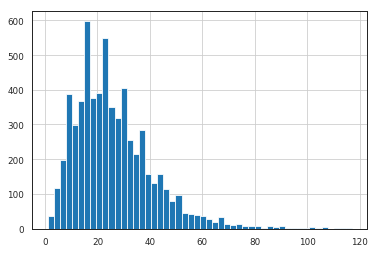

In [19]:
x.groupby('sent').size().hist(bins=50)

In [20]:
max_len = 80
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [21]:
from keras.preprocessing.sequence import pad_sequences
X = [[word2idx[w[0]] for w in s] for s in sents]

In [22]:
#X_real = [[word2idx[w[0]] for w in s] for s in real_test_sents]

In [23]:
X = pad_sequences(maxlen=max_len, sequences=X, value=word2idx["PAD"], padding='post', truncating='post')

In [24]:
X[1]

array([12417,  6532,  3008,  5065,  1814, 15739,  1814,  2103,  3008,
       17157,  4558,  9012, 16345, 14266,  1814,  2315, 14602,  1814,
       10446,  3008,  6864, 11822,  3008, 11249,  4069,  5561, 14519,
        1716,  3008,  9238,   693,  7068, 14520,   885, 13306, 11902,
        1814,  4021, 16825, 11297, 13310,  8700,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [25]:
pos = list(set(x["pos"].values))
n_pos = len(pos); n_pos

16

In [26]:
pos

['PRON',
 'AUX',
 'INTJ',
 'X',
 'VERB',
 'SCONJ',
 'ADJ',
 'PART',
 'NOUN',
 'ADV',
 'PROPN',
 'CCONJ',
 'NUM',
 'PUNCT',
 'ADP',
 'DET']

In [27]:
test_df.UPOS.unique()

array(['NNP', 'RB', 'VB', 'AT', 'NN', 'yyCM', 'CONJ', 'REL', 'COP', 'MD',
       'PREPOSITION', 'DEF', 'DTT', 'JJ', 'BN', 'yyDOT', 'NCD', 'NNT',
       'CD', 'POS', 'IN', 'CC', 'yyLRB', 'yyRRB', 'PRP', 'S_PRN', 'QW',
       'JJT', 'yyQUOT', 'BNT', 'CDT', 'yyCLN', 'P', 'EX', 'yySCLN',
       'TEMP', 'ADVERB', 'DT', 'yyEXCL', 'yyQM', 'INTJ'], dtype=object)

In [28]:
pos2idx = {w: i+1 for i, w in enumerate(pos)}
pos2idx["PAD"] = 0
X_pos = [[pos2idx[w[1]] for w in s] for s in sents]
X_pos = pad_sequences(maxlen=max_len, sequences=X_pos, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos[0]

array([13,  9,  5, 15, 11, 15, 11,  6,  1,  5, 15,  9, 14, 12, 10,  5,  9,
        7,  7, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

## True tags

In [29]:
y = [[tag2idx[w[2]] for w in s] for s in sents]
y_numer = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')

In [30]:
y_numer[1]

array([26,  5,  4,  4, 13, 29, 29,  8,  4,  4,  4,  4,  4,  4, 13, 29, 29,
       29,  8,  4, 26,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [31]:
from keras.utils import to_categorical
y = [to_categorical(i, num_classes=n_tags+1) for i in y_numer]
y[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## Perform train test splits

In [32]:
train_sents = list(sents.reset_index()[sents.index.str.startswith('train')].index)
dev_sents = list(sents.reset_index()[sents.index.str.startswith('dev')].index)
test_sents = list(sents.reset_index()[sents.index.str.startswith('test')].index)
len(train_sents), len(dev_sents), len(test_sents)

(5241, 484, 491)

In [33]:
X_tr, pos_tr, y_tr = X[train_sents], X_pos[train_sents], [y[i] for i in train_sents]
X_dev, pos_dev, y_dev = X[test_sents], X_pos[test_sents], [y[i] for i in test_sents]
X_te, pos_te, y_te = X[dev_sents], X_pos[dev_sents], [y[i] for i in dev_sents]

In [34]:
validation_split = len(X_dev) / (len(X_tr)+len(X_dev))
validation_split

0.08565945568736916

In [35]:
splits = [[np.concatenate([X_tr, X_dev], axis=0), X_te,
           np.concatenate([y_tr, y_dev], axis=0), y_te,
           np.concatenate([pos_tr, pos_dev], axis=0), pos_te ]]

### Prep char input

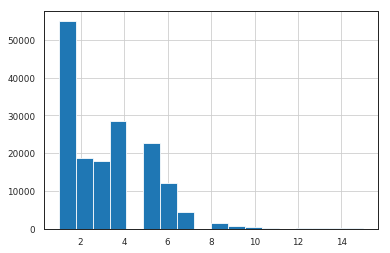

In [36]:
x.token.apply(len).hist(bins=18)

In [37]:
max_len_char = 10

In [38]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

49


In [39]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [40]:
X_char = []
for sentence in sents:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [41]:
X_char_tr = [X_char[i] for i in train_sents]
X_char_dev = [X_char[i] for i in test_sents]
X_char_te = [X_char[i] for i in dev_sents]
splits_char = [[np.concatenate([X_char_tr, X_char_dev], axis=0), X_char_te,
           np.concatenate([y_tr, y_dev], axis=0), y_te]]

## Embeddings

In [42]:
embedding_paths

{'yap_w2v_sg': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_skipgram.txt',
 'yap_w2v_cbow': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_cbow.txt',
 'yap_glove': '../wordembedding-hebrew/glove/wikipedia.yap_form.glove.txt.txt',
 'yap_ft_sg': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec',
 'yap_ft_cbow': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_cbow.model.vec',
 'token_w2v_sg': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_skipgram.txt',
 'token_w2v_cbow': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_cbow.txt',
 'token_glove': '../wordembedding-hebrew/glove/wikipedia.tokenized.glove.txt',
 'token_ft_sg': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_skipgram.model.vec',
 'token_ft_cbow': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_cbow.model.vec',
 'pretrained_token_ft': '../fasttext/wiki.he.vec'}

In [43]:
exclude = ['cbow']

In [44]:
embedding_mats = {}
for emb_name, emb_path in embedding_paths.items():
    skip=False
    for exc in exclude:
        if exc in emb_path:
            skip=True
    if skip:
        continue
    embedding_mats[emb_name] = get_embedding_matrix(emb_path, word2idx)

loading word embeddings: ../wordembedding-hebrew/wikipedia.yap_form.word2vec_skipgram.txt
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 1358
sample words not found:  ['מליה' 'פי.' 'גייסנו' 'גיי.' 'וולגארי' 'קאבררה' 'ואיה' 'באגו' '0003'
 'תאוזכר']
loading word embeddings: ../wordembedding-hebrew/glove/wikipedia.yap_form.glove.txt.txt
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 1358
sample words not found:  ['גילרדי' 'קארפיו' 'הופתעתי' 'תולשות' '2,075' 'אורווליאנית' 'מכופלת'
 'אחריה' 'לדידי' 'גילגלו']
loading word embeddings: ../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec
found 256508 word vectors
preparing embedding matrix...
number of null word embeddings: 1358
sample words not found:  ['129.90' 'משחדים' '1,005' 'בגנות' 'נקישתיות' 'חוליגאנים' '97125480'
 'הושחם' 'מיכרז' 'וולונטארי']
loading word embeddings: ../wordembedding-hebrew/wikipedia.tokenized.word2vec_skipgram.txt
found

## Model building

In [45]:
configs = build_configs(base_configs, embedding_mats)
configs     

[{'crf': True, 'use_pos': False},
 {'crf': True, 'use_pos': True},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_w2v_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_glove',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'yap_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_w2v_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_glove',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'token_ft_sg',
  'trainable': True,
  'embed_dim': 300},
 {'add_random_embedding': False,
  'crf': True,
  'use_

In [46]:
out_folder = 'outputs4'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

Train on 5241 samples, validate on 491 samples
Epoch 1/100
 - 62s - loss: 0.3292 - crf_accuracy: 0.9357 - val_loss: 0.1400 - val_crf_accuracy: 0.9744
Epoch 2/100
 - 57s - loss: 0.1327 - crf_accuracy: 0.9707 - val_loss: 0.1025 - val_crf_accuracy: 0.9762
Epoch 3/100
 - 56s - loss: 0.0884 - crf_accuracy: 0.9759 - val_loss: 0.0824 - val_crf_accuracy: 0.9784
Epoch 4/100
 - 56s - loss: 0.0593 - crf_accuracy: 0.9821 - val_loss: 0.0702 - val_crf_accuracy: 0.9788
Epoch 5/100
 - 57s - loss: 0.0416 - crf_accuracy: 0.9852 - val_loss: 0.0656 - val_crf_accuracy: 0.9771
Epoch 6/100
 - 57s - loss: 0.0294 - crf_accuracy: 0.9878 - val_loss: 0.0606 - val_crf_accuracy: 0.9769
Epoch 7/100
 - 57s - loss: 0.0199 - crf_accuracy: 0.9897 - val_loss: 0.0542 - val_crf_accuracy: 0.9790
Epoch 8/100
 - 55s - loss: 0.0122 - crf_accuracy: 0.9914 - val_loss: 0.0541 - val_crf_accuracy: 0.9776
Epoch 9/100
 - 56s - loss: 0.0054 - crf_accuracy: 0.9926 - val_loss: 0.0495 - val_crf_accuracy: 0.9769
Epoch 10/100
 - 57s - loss

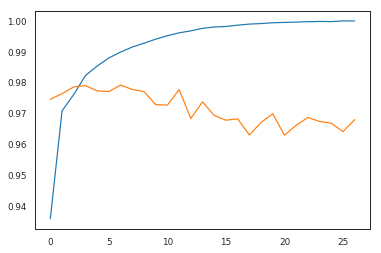

processed 11374 tokens with 488 phrases; found: 418 phrases; correct: 224.
accuracy:  44.69%; (non-O)
accuracy:  93.86%; precision:  53.59%; recall:  45.90%; FB1:  49.45
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              GPE: precision:  73.27%; recall:  61.67%; FB1:  66.97  101
              LOC: precision:  38.89%; recall:  26.92%; FB1:  31.82  18
              ORG: precision:  32.24%; recall:  42.61%; FB1:  36.70  152
              PER: precision:  63.95%; recall:  49.47%; FB1:  55.79  147
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 5241 samples, validate on 491 samples
Epoch 1/100
 - 59s - loss: 0.3026 - crf_accuracy: 0.9398 - val_loss: 0.1096 - val_crf_accuracy: 0.9747
Epoch 2/100
 - 55s - loss: 0.0967 

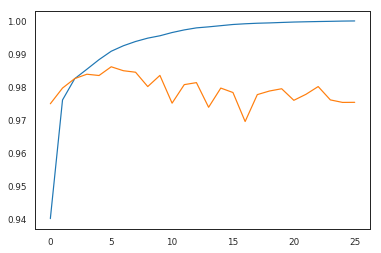

processed 11374 tokens with 488 phrases; found: 446 phrases; correct: 291.
accuracy:  52.28%; (non-O)
accuracy:  95.51%; precision:  65.25%; recall:  59.63%; FB1:  62.31
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              GPE: precision:  84.34%; recall:  58.33%; FB1:  68.97  83
              LOC: precision:  30.00%; recall:  23.08%; FB1:  26.09  20
              ORG: precision:  39.23%; recall:  44.35%; FB1:  41.63  130
              PER: precision:  77.00%; recall:  86.32%; FB1:  81.39  213
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 5241 samples, validate on 491 samples
Epoch 1/100
 - 62s - loss: 0.2839 - crf_accuracy: 0.9480 - val_loss: 0.1162 - val_crf_accuracy: 0.9758
Epoch 2/100
 - 56s - loss: 0.0893 -

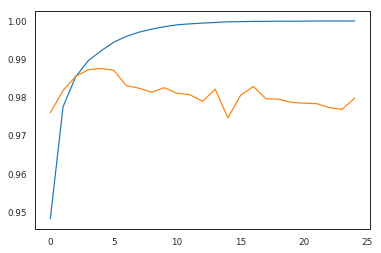

processed 11374 tokens with 488 phrases; found: 321 phrases; correct: 253.
accuracy:  50.76%; (non-O)
accuracy:  95.41%; precision:  78.82%; recall:  51.84%; FB1:  62.55
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              GPE: precision:  87.36%; recall:  63.33%; FB1:  73.43  87
              LOC: precision:  55.00%; recall:  42.31%; FB1:  47.83  20
              ORG: precision:  64.56%; recall:  44.35%; FB1:  52.58  79
              PER: precision:  86.47%; recall:  60.53%; FB1:  71.21  133
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
Train on 5241 samples, validate on 491 samples
Epoch 1/100
 - 62s - loss: 0.2251 - crf_accuracy: 0.9556 - val_loss: 0.0750 - val_crf_accuracy: 0.9790
Epoch 2/100
 - 57s - loss: 0.0660 - 

KeyboardInterrupt: 

In [47]:
configs, results, preds, histories = run_models(configs, splits, splits_char, embedding_mats, 
                                                words, max_len, n_words, idx2word, idx2tag,
                                                n_tags, max_len_char, n_pos, n_chars,
                                                run_name='treebank_realistic_swap', out_folder=out_folder,
                                                skip_if_model_exists=True,
                                                validation_split=validation_split,
                                                )

In [ ]:
results

In [46]:
for c in configs:
    if 'embedding_matrix' in c:
        c.update({'embedding_matrix': 'fastext'}) 

In [47]:
defaults = {'use_word': True, 'use_pos': False, 'embedding_matrix': None, 
            'embed_dim': 70, 'trainable': True, 'input_dropout': False, 
            'stack_lstm': 1, 'epochs': 100, 'early_stopping': True, 'patience': 20, 
            'min_delta': 0.0001, 'use_char': False, 'crf': False, 'stack_cross': False, 
            'stack_double': False, 'rec_dropout': 0.1}

In [48]:
for conf in configs:
    conf.update({'use_morpheme': True})
    conf.update({'use_word': False})

    for key in defaults:
        if key not in conf:
            conf[key] = defaults[key]

In [ ]:
len(list(zip(configs, results, preds, histories)))

In [52]:
def get_results_df(configs, results):
    dict_res = []
    for conf, res in zip(configs, results):
        dr = {}
        for i, r in enumerate(res):
            split_name = chr(ord('a')+i)
            dr['prec_'+split_name], dr['recall_'+split_name], dr['f1_'+split_name] = r
        dr.update(conf)
        dict_res.append(dr)
    rdf = (pd.DataFrame(dict_res)
           .assign(prec = lambda x: (x.prec_a + x.prec_b + x.prec_c)/3)
           .assign(recall = lambda x: (x.recall_a + x.recall_b + x.recall_c)/3)
           .assign(f1 = lambda x: (x.f1_a + x.f1_b + x.f1_c)/3))
    return rdf

In [53]:
res1 = pickle.load(open('treebank_results_1.pkl', 'rb'))

In [54]:
res2 = pickle.load(open('treebank_results_2_test25.pkl', 'rb'))

In [57]:
rdf1 = get_results_df([c for c, r, h in res1], [r for c, r, h in res1])

In [58]:
rdf2 = get_results_df([c for c, r, p, h in res2], [r for c, r, p, h in res2])

In [60]:
rdf2.head()

,crf,early_stopping,embed_dim,embedding_matrix,epochs,f1_a,f1_b,f1_c,input_dropout,min_delta,...,stack_double,stack_lstm,trainable,use_char,use_morpheme,use_pos,use_word,prec,recall,f1
0,True,True,70,None,100,61.595231,64.524986,63.937419,False,0.0001,...,False,1,True,False,True,False,False,66.866298,60.221498,63.352545
1,True,True,70,None,100,72.074967,71.615721,72.101911,False,0.0001,...,False,1,True,False,True,True,False,73.574440,70.383441,71.930866
2,True,True,300,fastext,100,77.924131,76.407437,77.421053,False,0.0001,...,False,1,True,False,True,False,False,78.371539,76.234033,77.250873
3,True,True,300,fastext,100,80.941052,79.862215,80.050761,False,0.0001,...,False,1,True,False,True,True,False,80.810288,79.768234,80.284676
4,True,True,70,None,100,69.732492,67.697498,70.299037,False,0.0001,...,False,1,True,True,True,False,False,74.882658,64.751970,69.243009


In [61]:
 (rdf2.fillna('No')
 .groupby(['use_char', 'use_pos', 'embedding_matrix'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[0,1])
 .round(1)
 )

use_char         False       True       
use_pos          False True  False True 
embedding_matrix                        
No                63.4  71.9  69.2  75.0
fastext           77.3  80.3  82.0  83.3

In [63]:
 (rdf1.fillna('No')
 .groupby(['use_char', 'use_pos', 'embedding_matrix'])
 .apply(lambda x: x.f1.mean())
 .unstack(level=[0,1])
 .round(1)
 )

use_char         False       True       
use_pos          False True  False True 
embedding_matrix                        
No                67.9  74.4  70.7  75.8
fastext           79.4  83.4  82.9  84.6